In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn.functional as F


import torchvision
from torchvision.models import resnet18, ResNet18_Weights, vgg16, VGG16_Weights
from torchvision import datasets
from torchvision import transforms

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


import os
from torchsummary import summary



# from google.colab import drive
# drive.mount('/content/drive')
# #Code folder path
# %cd /content/drive/My Drive/ECE591_DL_CL_PROJECT/

#device config
torch.cuda.set_device(1)#Select GPU device 1
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Datasets
#Tiny-imagenet: http://cs231n.stanford.edu/tiny-imagenet-200.zip
#Tiny-imagenet-C: https://zenodo.org/records/2469796

#CIFAR-10:  https://www.cs.toronto.edu/~kriz/cifar.html
#CIFAR-10C: https://zenodo.org/records/2535967


In [9]:
# Returns a list of transformations when called

class GetTransforms():
    '''Returns a list of transformations when type as requested amongst train/test
       Transforms('train') = list of transforms to apply on training data
       Transforms('test') = list of transforms to apply on testing data'''

    def __init__(self):
        pass

    def trainparams(self):
        train_transformations = [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation((-7,7)),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
            ]

        return train_transformations

    def testparams(self):
        test_transforms = [
            transforms.ToTensor(),
            transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)) #Normalize all the images
        ]
        return test_transforms

transformations = GetTransforms()
train_transforms = transforms.Compose(transformations.trainparams())#transforms.Compose(
test_transforms = transforms.Compose(transformations.testparams()) #transforms.Compose(

In [10]:
#Download CIFAR-10 Dataset
class GetCIFAR10_TrainData():
    def __init__(self, dir_name:str):
        self.dirname = dir_name

    def download_train_data(self):
        return datasets.CIFAR10(self.dirname, train=True, download=True, transform=train_transforms)

    def download_test_data(self):
        return datasets.CIFAR10(self.dirname, train=False, download=True, transform=test_transforms)

data = GetCIFAR10_TrainData('./Datasets/CIFAR-10')
trainset = data.download_train_data()
testset = data.download_test_data()


trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=512,shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
#following: https://www.kaggle.com/code/greatcodes/pytorch-cnn-resnet18-cifar10/notebook
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        DROPOUT = 0.0 #0.1 87.5%

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1) #the blocks we repeat have stride 1
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [12]:
def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):

    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target) #negative log likelihood loss


        train_losses.append(loss.item())
        loss.backward()
        optimizer.step() #Performs a single optimization step (parameter update).

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified = []):

    model.eval()
    test_loss = 0
    correct = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    # label = 0
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    with torch.no_grad():

        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            for d,i,j in zip(data, pred, target):
                if i != j:
                    misclassified.append([d.cpu(),i[0].cpu(),j.cpu()])

            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

    test_acc.append(100. * correct / len(test_dataloader.dataset))
    return misclassified


In [13]:
# Training the model
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)


train_acc = []
train_losses = []
test_acc = []
test_losses = []

EPOCHS = 100

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses)
    scheduler.step(train_losses[-1])
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)
    
    if i%10==0:
        torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0.pt")
        np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

torch.save(model.state_dict(), "./Networks/ResNet18_CIFAR10_V0.pt")
np.savez("./Networks/TrainSteps_ResNet18_CIFAR10_V0.npz", train_losses=train_losses,train_acc=train_acc, test_losses=test_losses, test_acc=test_acc)

EPOCHS : 0


Loss=1.4091037511825562 Batch_id=97 Accuracy=40.45: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s]



Test set: Average loss: 1.3292, Accuracy: 5077/10000 (50.77%)

EPOCHS : 1


Loss=1.0341383218765259 Batch_id=97 Accuracy=58.28: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s]



Test set: Average loss: 1.0876, Accuracy: 6077/10000 (60.77%)

EPOCHS : 2


Loss=0.9197078943252563 Batch_id=97 Accuracy=66.52: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.9429, Accuracy: 6696/10000 (66.96%)

EPOCHS : 3


Loss=0.7884930372238159 Batch_id=97 Accuracy=71.63: 100%|██████████| 98/98 [01:26<00:00,  1.14it/s]



Test set: Average loss: 0.9019, Accuracy: 6921/10000 (69.21%)

EPOCHS : 4


Loss=0.7197756767272949 Batch_id=97 Accuracy=75.58: 100%|██████████| 98/98 [01:26<00:00,  1.14it/s]



Test set: Average loss: 0.8178, Accuracy: 7287/10000 (72.87%)

EPOCHS : 5


Loss=0.587367594242096 Batch_id=97 Accuracy=78.06: 100%|██████████| 98/98 [01:25<00:00,  1.14it/s] 



Test set: Average loss: 0.7979, Accuracy: 7305/10000 (73.05%)

EPOCHS : 6


Loss=0.534168541431427 Batch_id=97 Accuracy=80.24: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]  



Test set: Average loss: 0.7008, Accuracy: 7679/10000 (76.79%)

EPOCHS : 7


Loss=0.5642014145851135 Batch_id=97 Accuracy=81.93: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s] 



Test set: Average loss: 0.6053, Accuracy: 7972/10000 (79.72%)

EPOCHS : 8


Loss=0.4799751043319702 Batch_id=97 Accuracy=82.81: 100%|██████████| 98/98 [01:27<00:00,  1.11it/s] 



Test set: Average loss: 0.5557, Accuracy: 8104/10000 (81.04%)

EPOCHS : 9


Loss=0.4397135376930237 Batch_id=97 Accuracy=84.20: 100%|██████████| 98/98 [01:27<00:00,  1.11it/s] 



Test set: Average loss: 0.5239, Accuracy: 8224/10000 (82.24%)

EPOCHS : 10


Loss=0.43259984254837036 Batch_id=97 Accuracy=85.28: 100%|██████████| 98/98 [01:25<00:00,  1.15it/s]



Test set: Average loss: 0.5772, Accuracy: 8137/10000 (81.37%)

EPOCHS : 11


Loss=0.34817585349082947 Batch_id=97 Accuracy=85.85: 100%|██████████| 98/98 [01:25<00:00,  1.14it/s]



Test set: Average loss: 0.5626, Accuracy: 8226/10000 (82.26%)

EPOCHS : 12


Loss=0.32398417592048645 Batch_id=97 Accuracy=87.18: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.7307, Accuracy: 7756/10000 (77.56%)

EPOCHS : 13


Loss=0.35503682494163513 Batch_id=97 Accuracy=87.75: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.4963, Accuracy: 8359/10000 (83.59%)

EPOCHS : 14


Loss=0.24580834805965424 Batch_id=97 Accuracy=88.36: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.5380, Accuracy: 8288/10000 (82.88%)

EPOCHS : 15


Loss=0.3038818836212158 Batch_id=97 Accuracy=89.22: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s] 



Test set: Average loss: 0.4854, Accuracy: 8444/10000 (84.44%)

EPOCHS : 16


Loss=0.2576802968978882 Batch_id=97 Accuracy=89.59: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s] 



Test set: Average loss: 0.4799, Accuracy: 8468/10000 (84.68%)

EPOCHS : 17


Loss=0.3003126382827759 Batch_id=97 Accuracy=89.89: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s] 

Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.



Test set: Average loss: 0.4776, Accuracy: 8497/10000 (84.97%)

EPOCHS : 18


Loss=0.24395470321178436 Batch_id=97 Accuracy=92.56: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.3545, Accuracy: 8807/10000 (88.07%)

EPOCHS : 19


Loss=0.16433393955230713 Batch_id=97 Accuracy=93.51: 100%|██████████| 98/98 [01:26<00:00,  1.14it/s]



Test set: Average loss: 0.3470, Accuracy: 8844/10000 (88.44%)

EPOCHS : 20


Loss=0.19615156948566437 Batch_id=97 Accuracy=94.01: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.3480, Accuracy: 8857/10000 (88.57%)

EPOCHS : 21


Loss=0.2627497613430023 Batch_id=97 Accuracy=94.10: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s] 



Test set: Average loss: 0.3425, Accuracy: 8887/10000 (88.87%)

EPOCHS : 22


Loss=0.1589071899652481 Batch_id=97 Accuracy=94.55: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s] 



Test set: Average loss: 0.3436, Accuracy: 8879/10000 (88.79%)

EPOCHS : 23


Loss=0.20786616206169128 Batch_id=97 Accuracy=94.58: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.3444, Accuracy: 8892/10000 (88.92%)

EPOCHS : 24


Loss=0.17027002573013306 Batch_id=97 Accuracy=94.59: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.3417, Accuracy: 8902/10000 (89.02%)

EPOCHS : 25


Loss=0.12004661560058594 Batch_id=97 Accuracy=94.82: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.3435, Accuracy: 8886/10000 (88.86%)

EPOCHS : 26


Loss=0.10960749536752701 Batch_id=97 Accuracy=94.90: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.3443, Accuracy: 8898/10000 (88.98%)

EPOCHS : 27


Loss=0.15332524478435516 Batch_id=97 Accuracy=95.06: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.3426, Accuracy: 8896/10000 (88.96%)

EPOCHS : 28


Loss=0.16073034703731537 Batch_id=97 Accuracy=95.06: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.3433, Accuracy: 8891/10000 (88.91%)

EPOCHS : 29


Loss=0.16069395840168 Batch_id=97 Accuracy=95.26: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]   

Epoch 00030: reducing learning rate of group 0 to 2.5000e-05.



Test set: Average loss: 0.3483, Accuracy: 8874/10000 (88.74%)

EPOCHS : 30


Loss=0.13158223032951355 Batch_id=97 Accuracy=95.29: 100%|██████████| 98/98 [01:27<00:00,  1.11it/s]



Test set: Average loss: 0.3434, Accuracy: 8904/10000 (89.04%)

EPOCHS : 31


Loss=0.13038644194602966 Batch_id=97 Accuracy=95.34: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.3438, Accuracy: 8903/10000 (89.03%)

EPOCHS : 32


Loss=0.16062882542610168 Batch_id=97 Accuracy=95.34: 100%|██████████| 98/98 [01:26<00:00,  1.14it/s]

Epoch 00033: reducing learning rate of group 0 to 1.2500e-06.



Test set: Average loss: 0.3433, Accuracy: 8903/10000 (89.03%)

EPOCHS : 33


Loss=0.15698520839214325 Batch_id=97 Accuracy=95.24: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.3422, Accuracy: 8908/10000 (89.08%)

EPOCHS : 34


Loss=0.14915354549884796 Batch_id=97 Accuracy=95.33: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.3426, Accuracy: 8913/10000 (89.13%)

EPOCHS : 35


Loss=0.11978327482938766 Batch_id=97 Accuracy=95.31: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]

Epoch 00036: reducing learning rate of group 0 to 6.2500e-08.



Test set: Average loss: 0.3433, Accuracy: 8900/10000 (89.00%)

EPOCHS : 36


Loss=0.16991282999515533 Batch_id=97 Accuracy=95.45: 100%|██████████| 98/98 [01:25<00:00,  1.14it/s]



Test set: Average loss: 0.3432, Accuracy: 8907/10000 (89.07%)

EPOCHS : 37


Loss=0.13184002041816711 Batch_id=97 Accuracy=95.34: 100%|██████████| 98/98 [01:28<00:00,  1.11it/s]



Test set: Average loss: 0.3432, Accuracy: 8903/10000 (89.03%)

EPOCHS : 38


Loss=0.13968107104301453 Batch_id=97 Accuracy=95.09: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]

Epoch 00039: reducing learning rate of group 0 to 3.1250e-09.



Test set: Average loss: 0.3426, Accuracy: 8911/10000 (89.11%)

EPOCHS : 39


Loss=0.17930595576763153 Batch_id=97 Accuracy=95.33: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.3430, Accuracy: 8901/10000 (89.01%)

EPOCHS : 40


Loss=0.1613636016845703 Batch_id=97 Accuracy=95.45: 100%|██████████| 98/98 [01:28<00:00,  1.11it/s] 



Test set: Average loss: 0.3434, Accuracy: 8904/10000 (89.04%)

EPOCHS : 41


Loss=0.13629621267318726 Batch_id=97 Accuracy=95.29: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.3440, Accuracy: 8898/10000 (88.98%)

EPOCHS : 42


Loss=0.12558089196681976 Batch_id=97 Accuracy=95.26: 100%|██████████| 98/98 [01:28<00:00,  1.11it/s]



Test set: Average loss: 0.3433, Accuracy: 8908/10000 (89.08%)

EPOCHS : 43


Loss=0.15276619791984558 Batch_id=97 Accuracy=95.41: 100%|██████████| 98/98 [01:28<00:00,  1.11it/s]



Test set: Average loss: 0.3441, Accuracy: 8901/10000 (89.01%)

EPOCHS : 44


Loss=0.1324928104877472 Batch_id=97 Accuracy=95.45: 100%|██████████| 98/98 [01:28<00:00,  1.11it/s] 



Test set: Average loss: 0.3422, Accuracy: 8908/10000 (89.08%)

EPOCHS : 45


Loss=0.09702245146036148 Batch_id=97 Accuracy=95.33: 100%|██████████| 98/98 [01:26<00:00,  1.13it/s]



Test set: Average loss: 0.3434, Accuracy: 8903/10000 (89.03%)

EPOCHS : 46


Loss=0.13601288199424744 Batch_id=97 Accuracy=95.52: 100%|██████████| 98/98 [01:27<00:00,  1.11it/s]



Test set: Average loss: 0.3433, Accuracy: 8900/10000 (89.00%)

EPOCHS : 47


Loss=0.12522050738334656 Batch_id=97 Accuracy=95.50: 100%|██████████| 98/98 [01:27<00:00,  1.11it/s]



Test set: Average loss: 0.3425, Accuracy: 8908/10000 (89.08%)

EPOCHS : 48


Loss=0.15077130496501923 Batch_id=97 Accuracy=95.31: 100%|██████████| 98/98 [01:28<00:00,  1.11it/s]



Test set: Average loss: 0.3430, Accuracy: 8905/10000 (89.05%)

EPOCHS : 49


Loss=0.14062456786632538 Batch_id=97 Accuracy=95.49: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.3438, Accuracy: 8899/10000 (88.99%)

EPOCHS : 50


Loss=0.12895235419273376 Batch_id=97 Accuracy=95.49: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.3429, Accuracy: 8901/10000 (89.01%)

EPOCHS : 51


Loss=0.1738623082637787 Batch_id=97 Accuracy=95.35: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s] 



Test set: Average loss: 0.3427, Accuracy: 8908/10000 (89.08%)

EPOCHS : 52


Loss=0.1676381677389145 Batch_id=97 Accuracy=95.42: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s] 



Test set: Average loss: 0.3435, Accuracy: 8898/10000 (88.98%)

EPOCHS : 53


Loss=0.13425059616565704 Batch_id=97 Accuracy=95.38: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.3427, Accuracy: 8905/10000 (89.05%)

EPOCHS : 54


Loss=0.11556082963943481 Batch_id=97 Accuracy=95.50: 100%|██████████| 98/98 [01:28<00:00,  1.11it/s]



Test set: Average loss: 0.3434, Accuracy: 8897/10000 (88.97%)

EPOCHS : 55


Loss=0.1661374866962433 Batch_id=97 Accuracy=95.40: 100%|██████████| 98/98 [01:23<00:00,  1.17it/s] 



Test set: Average loss: 0.3433, Accuracy: 8911/10000 (89.11%)

EPOCHS : 56


Loss=0.17028844356536865 Batch_id=97 Accuracy=95.40: 100%|██████████| 98/98 [01:04<00:00,  1.51it/s]



Test set: Average loss: 0.3438, Accuracy: 8905/10000 (89.05%)

EPOCHS : 57


Loss=0.14781679213047028 Batch_id=97 Accuracy=95.29: 100%|██████████| 98/98 [00:57<00:00,  1.70it/s]



Test set: Average loss: 0.3433, Accuracy: 8899/10000 (88.99%)

EPOCHS : 58


Loss=0.131788969039917 Batch_id=97 Accuracy=95.32: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]  



Test set: Average loss: 0.3424, Accuracy: 8902/10000 (89.02%)

EPOCHS : 59


Loss=0.09862479567527771 Batch_id=97 Accuracy=95.35: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.3431, Accuracy: 8903/10000 (89.03%)

EPOCHS : 60


Loss=0.16712810099124908 Batch_id=97 Accuracy=95.37: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.3432, Accuracy: 8902/10000 (89.02%)

EPOCHS : 61


Loss=0.1519797146320343 Batch_id=97 Accuracy=95.34: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s] 



Test set: Average loss: 0.3432, Accuracy: 8910/10000 (89.10%)

EPOCHS : 62


Loss=0.15343503654003143 Batch_id=97 Accuracy=95.38: 100%|██████████| 98/98 [00:43<00:00,  2.26it/s]



Test set: Average loss: 0.3427, Accuracy: 8906/10000 (89.06%)

EPOCHS : 63


Loss=0.13968110084533691 Batch_id=97 Accuracy=95.39: 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]



Test set: Average loss: 0.3425, Accuracy: 8908/10000 (89.08%)

EPOCHS : 64


Loss=0.11357433348894119 Batch_id=97 Accuracy=95.22: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]



Test set: Average loss: 0.3428, Accuracy: 8905/10000 (89.05%)

EPOCHS : 65


Loss=0.1452115774154663 Batch_id=97 Accuracy=95.38: 100%|██████████| 98/98 [00:44<00:00,  2.23it/s] 



Test set: Average loss: 0.3433, Accuracy: 8908/10000 (89.08%)

EPOCHS : 66


Loss=0.1433326005935669 Batch_id=97 Accuracy=95.30: 100%|██████████| 98/98 [00:43<00:00,  2.23it/s] 



Test set: Average loss: 0.3429, Accuracy: 8909/10000 (89.09%)

EPOCHS : 67


Loss=0.11023737490177155 Batch_id=97 Accuracy=95.34: 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]



Test set: Average loss: 0.3425, Accuracy: 8903/10000 (89.03%)

EPOCHS : 68


Loss=0.17888370156288147 Batch_id=97 Accuracy=95.33: 100%|██████████| 98/98 [00:44<00:00,  2.20it/s]



Test set: Average loss: 0.3430, Accuracy: 8905/10000 (89.05%)

EPOCHS : 69


Loss=0.14862468838691711 Batch_id=97 Accuracy=95.36: 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]



Test set: Average loss: 0.3433, Accuracy: 8899/10000 (88.99%)

EPOCHS : 70


Loss=0.17407700419425964 Batch_id=97 Accuracy=95.28: 100%|██████████| 98/98 [00:35<00:00,  2.78it/s]



Test set: Average loss: 0.3425, Accuracy: 8911/10000 (89.11%)

EPOCHS : 71


Loss=0.17948512732982635 Batch_id=97 Accuracy=95.25: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.3434, Accuracy: 8905/10000 (89.05%)

EPOCHS : 72


Loss=0.09363345056772232 Batch_id=97 Accuracy=95.41: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]



Test set: Average loss: 0.3429, Accuracy: 8901/10000 (89.01%)

EPOCHS : 73


Loss=0.15750429034233093 Batch_id=97 Accuracy=95.40: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]



Test set: Average loss: 0.3433, Accuracy: 8905/10000 (89.05%)

EPOCHS : 74


Loss=0.11616567522287369 Batch_id=97 Accuracy=95.31: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]



Test set: Average loss: 0.3432, Accuracy: 8903/10000 (89.03%)

EPOCHS : 75


Loss=0.166087344288826 Batch_id=97 Accuracy=95.47: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]  



Test set: Average loss: 0.3434, Accuracy: 8899/10000 (88.99%)

EPOCHS : 76


Loss=0.1684601604938507 Batch_id=97 Accuracy=95.38: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s] 



Test set: Average loss: 0.3435, Accuracy: 8904/10000 (89.04%)

EPOCHS : 77


Loss=0.21513795852661133 Batch_id=97 Accuracy=95.35: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.3433, Accuracy: 8904/10000 (89.04%)

EPOCHS : 78


Loss=0.1464255005121231 Batch_id=97 Accuracy=95.38: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s] 



Test set: Average loss: 0.3436, Accuracy: 8906/10000 (89.06%)

EPOCHS : 79


Loss=0.1400504857301712 Batch_id=97 Accuracy=95.35: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s] 



Test set: Average loss: 0.3432, Accuracy: 8901/10000 (89.01%)

EPOCHS : 80


Loss=0.1266191303730011 Batch_id=97 Accuracy=95.26: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s] 



Test set: Average loss: 0.3433, Accuracy: 8904/10000 (89.04%)

EPOCHS : 81


Loss=0.1515250951051712 Batch_id=97 Accuracy=95.43: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s] 



Test set: Average loss: 0.3434, Accuracy: 8903/10000 (89.03%)

EPOCHS : 82


Loss=0.13526932895183563 Batch_id=97 Accuracy=95.25: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.3438, Accuracy: 8896/10000 (88.96%)

EPOCHS : 83


Loss=0.13422399759292603 Batch_id=97 Accuracy=95.41: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]



Test set: Average loss: 0.3436, Accuracy: 8902/10000 (89.02%)

EPOCHS : 84


Loss=0.12922632694244385 Batch_id=97 Accuracy=95.32: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 0.3432, Accuracy: 8913/10000 (89.13%)

EPOCHS : 85


Loss=0.1574932187795639 Batch_id=97 Accuracy=95.28: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s] 



Test set: Average loss: 0.3430, Accuracy: 8910/10000 (89.10%)

EPOCHS : 86


Loss=0.13981445133686066 Batch_id=97 Accuracy=95.43: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.3440, Accuracy: 8903/10000 (89.03%)

EPOCHS : 87


Loss=0.13778908550739288 Batch_id=97 Accuracy=95.34: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]



Test set: Average loss: 0.3431, Accuracy: 8905/10000 (89.05%)

EPOCHS : 88


Loss=0.11255281418561935 Batch_id=97 Accuracy=95.44: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.3435, Accuracy: 8903/10000 (89.03%)

EPOCHS : 89


Loss=0.1585870236158371 Batch_id=97 Accuracy=95.30: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s] 



Test set: Average loss: 0.3435, Accuracy: 8905/10000 (89.05%)

EPOCHS : 90


Loss=0.15156181156635284 Batch_id=97 Accuracy=95.43: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]



Test set: Average loss: 0.3435, Accuracy: 8906/10000 (89.06%)

EPOCHS : 91


Loss=0.1196722611784935 Batch_id=97 Accuracy=95.32: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s] 



Test set: Average loss: 0.3438, Accuracy: 8898/10000 (88.98%)

EPOCHS : 92


Loss=0.11798271536827087 Batch_id=97 Accuracy=95.32: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.3438, Accuracy: 8903/10000 (89.03%)

EPOCHS : 93


Loss=0.20521385967731476 Batch_id=97 Accuracy=95.35: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]



Test set: Average loss: 0.3435, Accuracy: 8897/10000 (88.97%)

EPOCHS : 94


Loss=0.1447332203388214 Batch_id=97 Accuracy=95.36: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s] 



Test set: Average loss: 0.3446, Accuracy: 8907/10000 (89.07%)

EPOCHS : 95


Loss=0.1881573498249054 Batch_id=97 Accuracy=95.35: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s] 



Test set: Average loss: 0.3430, Accuracy: 8904/10000 (89.04%)

EPOCHS : 96


Loss=0.1443435251712799 Batch_id=97 Accuracy=95.43: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s] 



Test set: Average loss: 0.3425, Accuracy: 8905/10000 (89.05%)

EPOCHS : 97


Loss=0.16439345479011536 Batch_id=97 Accuracy=95.36: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]



Test set: Average loss: 0.3430, Accuracy: 8900/10000 (89.00%)

EPOCHS : 98


Loss=0.14109471440315247 Batch_id=97 Accuracy=95.45: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 0.3433, Accuracy: 8905/10000 (89.05%)

EPOCHS : 99


Loss=0.15149818360805511 Batch_id=97 Accuracy=95.29: 100%|██████████| 98/98 [00:21<00:00,  4.47it/s]



Test set: Average loss: 0.3436, Accuracy: 8904/10000 (89.04%)



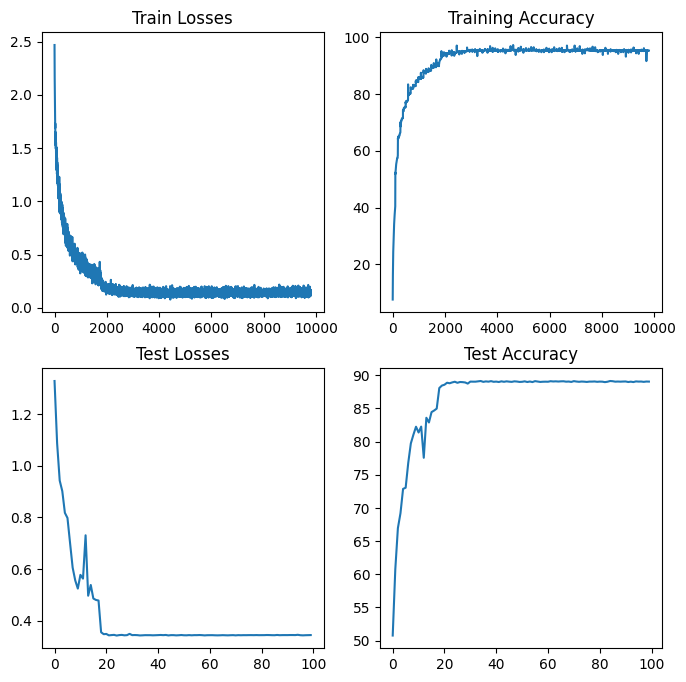

In [14]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

axs[0,0].set_title('Train Losses')
axs[0,1].set_title('Training Accuracy')
axs[1,0].set_title('Test Losses')
axs[1,1].set_title('Test Accuracy')

axs[0,0].plot(train_losses)
axs[0,1].plot(train_acc)
axs[1,0].plot(test_losses)
axs[1,1].plot(test_acc)